In [24]:
import contextlib
import ipynb.fs
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import torch
import wave

from collections import defaultdict
from scipy.io import wavfile
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn import tree
from tqdm import tqdm

from .defs.formant_vowel_prediction import vowel_prediction, vowel_prediction_sd
from .defs.vowel_feedback_function import vowel_feedback
from .defs.extract_formant import extract_formant

random_state=42
torch.manual_seed(random_state)

In [25]:
folder = '../../allwavs/allvowl/corrected/extracted'
files = os.listdir(folder)

In [26]:
# def trim_wav(in_wav, out_wav, start, end):
#     sample_rate, wave_data = wavfile.read(in_wav)
#     start_sample = int(start * sample_rate)
#     end_sample = int(end * sample_rate)
#     wavfile.write(out_wav, sample_rate, wave_data[start_sample:end_sample])
# 
# for file in tqdm(files):
#     if file == 'trimmed' or file == 'img':
#         continue
#     start, end = file.split('__')[2:4]
#     start = float(start)
#     end = float(end)
#     trim_wav(folder + '/' + file, folder + '/trimmed/' + file, start, end)

In [27]:
v_files = os.listdir(folder + '/trimmed')
cnt = 0
n_formants = 4

vowels = defaultdict(list)

for file in tqdm(v_files):
    if file == 'img':
        continue
    path = folder + '/trimmed/' + file
    with contextlib.closing(wave.open(path, 'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
    try:
        formants = extract_formant(path, f0min=math.ceil(3/duration + 0.000001), n_formants=n_formants)
        vowel, gender, start, end, phonemes, word, orig_file = file.split('__')
        vowel = vowel.replace('E+', 'e').replace('@', '2')
        if len(phonemes) == 1:
            phonemes = '_'.join(list(word.replace('1', ''))).replace('u', 'y')
        elif len(phonemes) == 2:
            phonemes = 't_E+'
        elif len(phonemes) == 3 and '_' not in phonemes:
            phonemes = 't_U~+'
        vowels[vowel].append([*formants, gender, phonemes.split('_')[0]])
        #print(vowel, gender, phonemes, word, *formants)
    except ZeroDivisionError:
        cnt += 1
        continue
        
print(cnt)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5575/5575 [02:03<00:00, 45.31it/s]

464


In [28]:
fs = [defaultdict(list) for i in range(n_formants)]
for key, val in vowels.items():
    for formants in val:
        for i in range(n_formants):
            fs[i][key].append(formants[i])

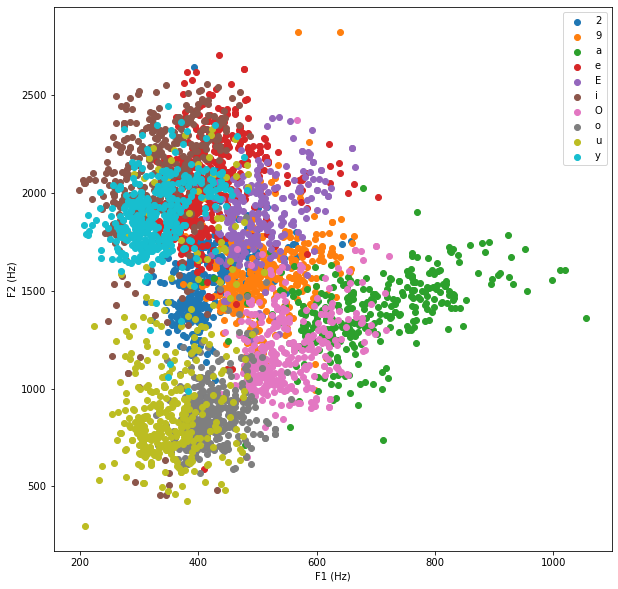

In [38]:
plt.figure(figsize=(10, 10))
for key in fs[0]:
    if '~' not in key:
        plt.scatter(fs[0][key], fs[1][key], label=key)
plt.xlabel('F1 (Hz)')
plt.ylabel('F2 (Hz)')
plt.legend()
plt.savefig('all_vowels.png')
plt.show()

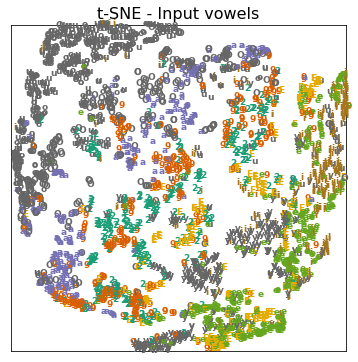

In [47]:
key2idx = {key: i for i, key in enumerate(vowels.keys())}
idx2key = {i: key for key, i in key2idx.items()}

include_nasals = False

def plot_tsne_embeddings(X, y, title):
    y = y.astype(int)
    X = QuantileTransformer(n_quantiles=len(X)).fit_transform(X)
    plt.figure(figsize = (6, 6))
    for i in range(X.shape[0]):        
        plt.text(X[i, 0],
                 X[i, 1],
                 idx2key[y[i]],
                 color=plt.cm.Dark2(y[i]),
                 fontdict={"weight": "bold", "size": 9})
    plt.xticks([]), plt.yticks([])
    plt.title('t-SNE - ' + title, fontsize=16)
    plt.show()
    return

len_dataset = sum(len(val) for val in vowels.values())
if not include_nasals:
    len_dataset -= sum(len(vowels[k]) for k in vowels.keys() if '~' in k)

formants_tot = torch.empty((len_dataset, n_formants + 7), dtype=torch.float)
labels_tot = torch.empty(len_dataset, dtype=torch.float)

i = 0
for key, val in vowels.items():
    if '~' in key and not include_nasals:
        continue
    for val2 in val:
        val2 = val2.copy()
        labels_tot[i] = key2idx[key]
        val2[n_formants] = int(val2[n_formants] == 'f')
        val2[n_formants + 1] = int(val2[n_formants + 1] == 'l')
        val2 += [0, 0, 0, 0, 0]
        val2[n_formants + 2] = int(val2[n_formants + 1] == 'm')
        val2[n_formants + 3] = int(val2[n_formants + 1] == 'p')
        val2[n_formants + 4] = int(val2[n_formants + 1] == 's')
        val2[n_formants + 5] = int(val2[n_formants + 1] == 't')
        val2[n_formants + 6] = int(val2[n_formants + 1] == 't1')
        formants_tot[i] = torch.FloatTensor(val2)
        i += 1

indices = torch.randperm(formants_tot.size()[0])
formants_tot = formants_tot[indices]
labels_tot = labels_tot[indices]
        
formants_tot = formants_tot.numpy()
labels_tot = labels_tot.numpy()

formants_TSNE = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(formants_tot)

plot_tsne_embeddings(formants_TSNE, labels_tot, 'Input vowels')

In [51]:
scaler = StandardScaler().fit(formants_tot[:, :n_formants])
formants_tot[:, :n_formants] = scaler.transform(formants_tot[:, :n_formants])

X_train, X_test, y_train, y_test = train_test_split(formants_tot, labels_tot, test_size=0.1, random_state=random_state)

feature_names = ['F' + str(i + 1) for i in range(n_formants)] + ['isF', 'm-', 'l-', 'p-', 's-', 't-', 't1-']
target_names = [idx2key[x] for x in [0, 1, 2, 4, 5, 6, 7, 8, 10, 12]]
classifiers = []

## Decision trees

              precision    recall  f1-score   support

           2     0.6875    0.8462    0.7586        26
           9     0.7250    0.7436    0.7342        39
           a     0.7857    0.6875    0.7333        32
           e     0.8378    0.7561    0.7949        41
           E     0.5769    0.6818    0.6250        22
           i     0.7872    0.7551    0.7708        49
           O     0.6579    0.6579    0.6579        38
           o     0.6667    0.8387    0.7429        31
           u     0.8684    0.5893    0.7021        56
           y     0.6818    0.8571    0.7595        35

    accuracy                         0.7317       369
   macro avg     0.7275    0.7413    0.7279       369
weighted avg     0.7455    0.7317    0.7313       369



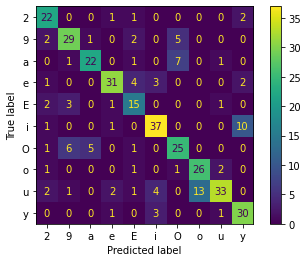

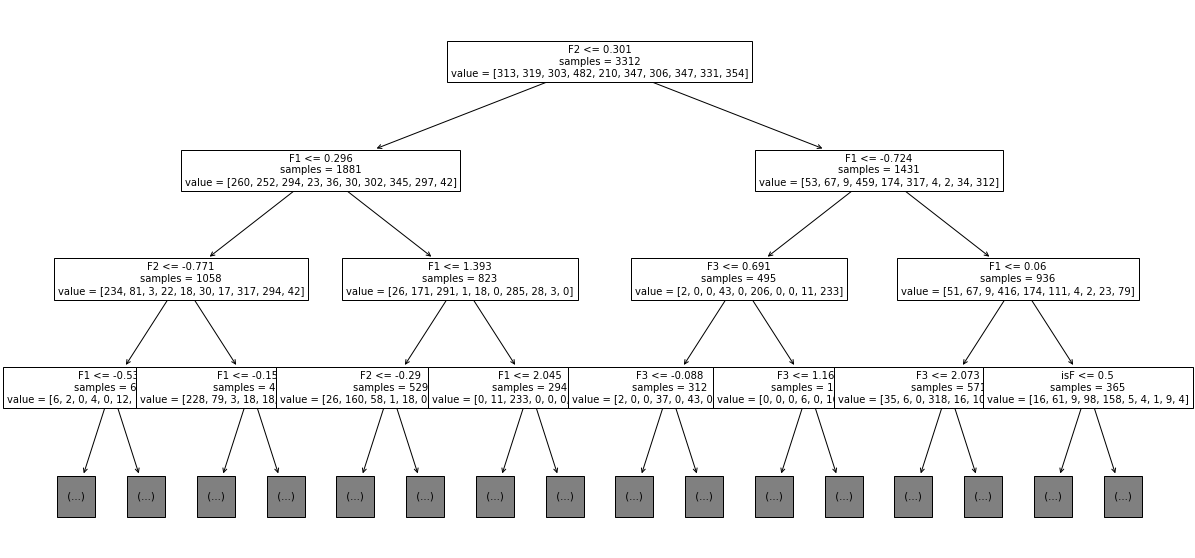

In [52]:
clf = tree.DecisionTreeClassifier(random_state=random_state)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
plt.show()
ax = plt.figure(figsize=(20, 10)).gca()
tree.plot_tree(clf, ax=ax, max_depth=3, fontsize=10, impurity=False, feature_names=feature_names)
classifiers.append(('DecisionTree', clf))
plt.show()

## Logistic Regression

              precision    recall  f1-score   support

           2     0.7407    0.7692    0.7547        26
           9     0.6829    0.7179    0.7000        39
           a     0.9091    0.6250    0.7407        32
           e     0.7447    0.8537    0.7955        41
           E     0.7895    0.6818    0.7317        22
           i     0.8409    0.7551    0.7957        49
           O     0.6939    0.8947    0.7816        38
           o     0.5714    0.7742    0.6575        31
           u     0.8571    0.5357    0.6593        56
           y     0.6512    0.8000    0.7179        35

    accuracy                         0.7344       369
   macro avg     0.7481    0.7407    0.7335       369
weighted avg     0.7560    0.7344    0.7330       369



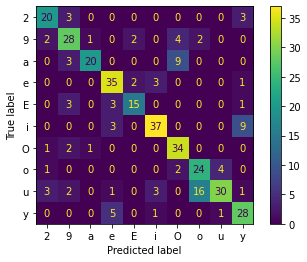

In [61]:
clf = LogisticRegression(random_state=random_state)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('Logistic Regression', clf))
plt.show()

## K Neighbors

              precision    recall  f1-score   support

           2     0.6061    0.7692    0.6780        26
           9     0.7419    0.5897    0.6571        39
           a     0.8276    0.7500    0.7869        32
           e     0.6957    0.7805    0.7356        41
           E     0.7895    0.6818    0.7317        22
           i     0.8163    0.8163    0.8163        49
           O     0.7750    0.8158    0.7949        38
           o     0.6279    0.8710    0.7297        31
           u     0.9412    0.5714    0.7111        56
           y     0.7111    0.9143    0.8000        35

    accuracy                         0.7480       369
   macro avg     0.7532    0.7560    0.7441       369
weighted avg     0.7685    0.7480    0.7462       369



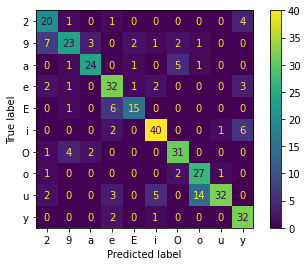

In [54]:
clf = KNeighborsClassifier(n_neighbors=1)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('K Neighbors', clf))
plt.show()

## Multilayer Perceptron

              precision    recall  f1-score   support

           2     0.8261    0.7308    0.7755        26
           9     0.7561    0.7949    0.7750        39
           a     0.8519    0.7188    0.7797        32
           e     0.8095    0.8293    0.8193        41
           E     0.7600    0.8636    0.8085        22
           i     0.8400    0.8571    0.8485        49
           O     0.8049    0.8684    0.8354        38
           o     0.6667    0.9032    0.7671        31
           u     0.9189    0.6071    0.7312        56
           y     0.7805    0.9143    0.8421        35

    accuracy                         0.7995       369
   macro avg     0.8015    0.8088    0.7982       369
weighted avg     0.8112    0.7995    0.7974       369



/home/anfasa/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


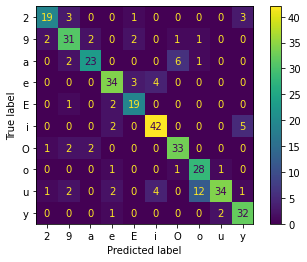

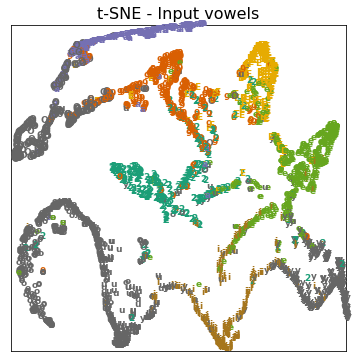

In [55]:
clf = MLPClassifier(random_state=random_state, hidden_layer_sizes=(40, 50), activation='tanh')
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('Multilayer Perceptron', clf))
plt.show()

activation = formants_tot
hidden_activation = ACTIVATIONS[clf.activation]
for i in range(clf.n_layers_ - 1):
    activation = np.dot(activation, clf.coefs_[i])
    activation += clf.intercepts_[i]
    if i != clf.n_layers_ - 2:
        hidden_activation(activation)
output_activation = ACTIVATIONS[clf.out_activation_]
output_activation(activation)

formants_TSNE = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(activation)
plot_tsne_embeddings(formants_TSNE, labels_tot, 'Input vowels')

## Random forests

              precision    recall  f1-score   support

           2     0.7857    0.8462    0.8148        26
           9     0.7692    0.7692    0.7692        39
           a     1.0000    0.6250    0.7692        32
           e     0.7727    0.8293    0.8000        41
           E     0.8333    0.9091    0.8696        22
           i     0.8077    0.8571    0.8317        49
           O     0.6957    0.8421    0.7619        38
           o     0.6750    0.8710    0.7606        31
           u     0.9474    0.6429    0.7660        56
           y     0.8158    0.8857    0.8493        35

    accuracy                         0.7967       369
   macro avg     0.8103    0.8078    0.7992       369
weighted avg     0.8157    0.7967    0.7958       369



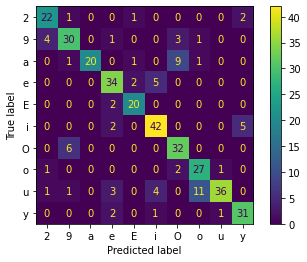

In [56]:
clf = RandomForestClassifier(random_state=random_state, n_estimators=500)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('Random forest', clf))
plt.show()

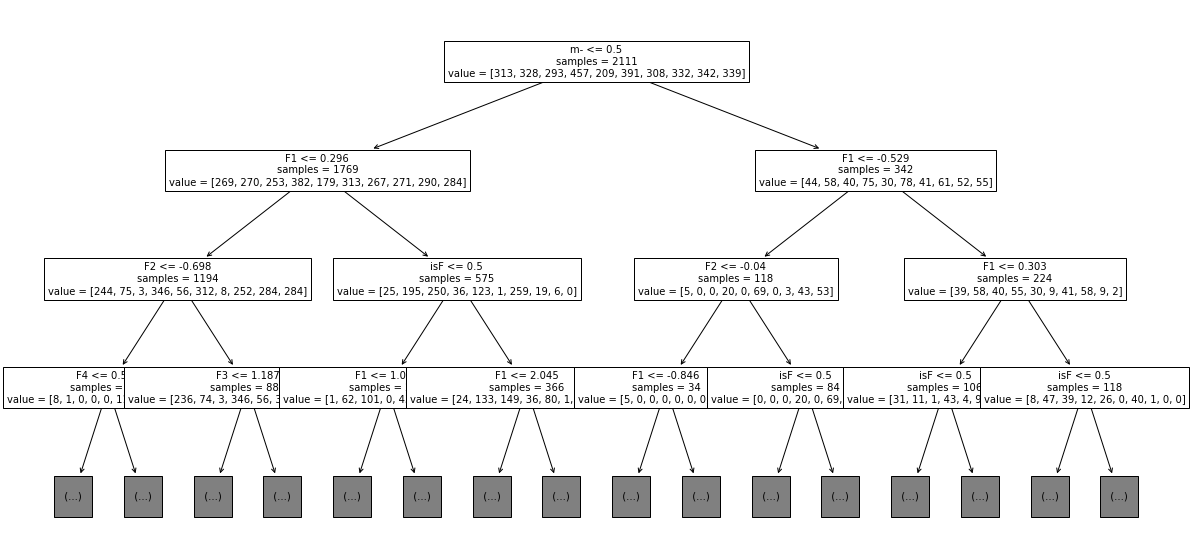

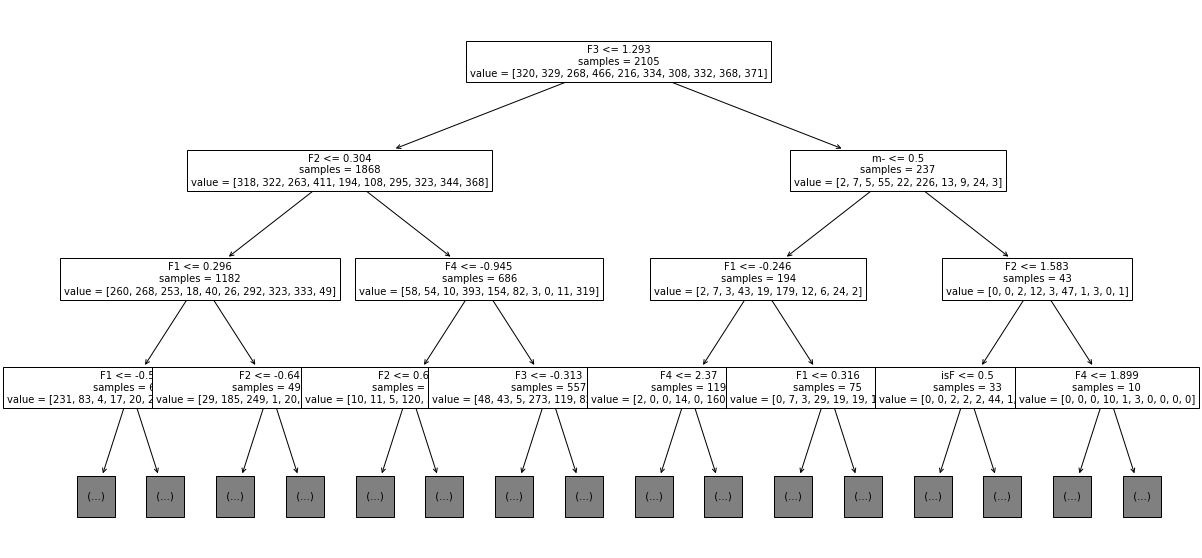

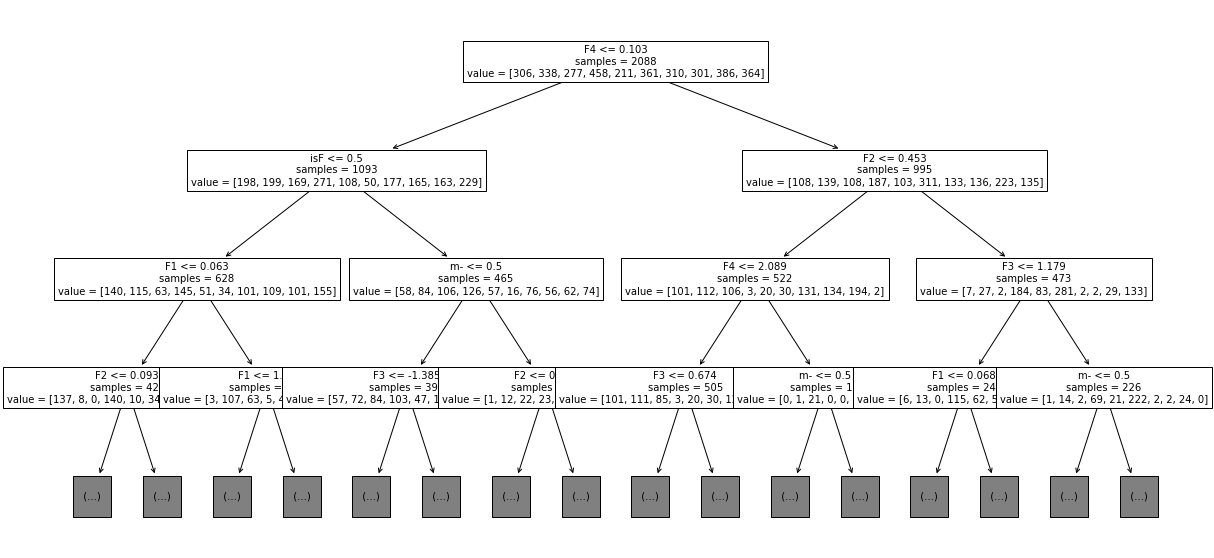

In [14]:
for estimator in clf.estimators_[:3]:
    ax = plt.figure(figsize=(20, 10)).gca()
    tree.plot_tree(estimator, ax=ax, max_depth=3, fontsize=10, impurity=False, feature_names=feature_names)
    plt.show()

## Extra trees

              precision    recall  f1-score   support

           2     0.7419    0.8846    0.8070        26
           9     0.8000    0.7179    0.7568        39
           a     0.9167    0.6875    0.7857        32
           e     0.7826    0.8780    0.8276        41
           E     0.8636    0.8636    0.8636        22
           i     0.8200    0.8367    0.8283        49
           O     0.7442    0.8421    0.7901        38
           o     0.6667    0.9032    0.7671        31
           u     0.9459    0.6250    0.7527        56
           y     0.7949    0.8857    0.8378        35

    accuracy                         0.7995       369
   macro avg     0.8077    0.8125    0.8017       369
weighted avg     0.8153    0.7995    0.7979       369



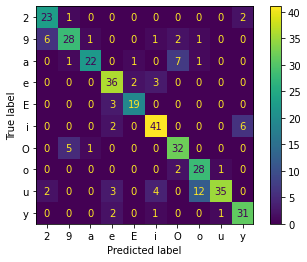

In [57]:
clf = ExtraTreesClassifier(random_state=random_state, n_estimators=400)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('Extra trees', clf))
plt.show()

## Bagging

              precision    recall  f1-score   support

           2     0.8462    0.8462    0.8462        26
           9     0.7381    0.7949    0.7654        39
           a     0.9545    0.6562    0.7778        32
           e     0.8250    0.8049    0.8148        41
           E     0.7407    0.9091    0.8163        22
           i     0.7736    0.8367    0.8039        49
           O     0.7045    0.8158    0.7561        38
           o     0.6842    0.8387    0.7536        31
           u     0.9730    0.6429    0.7742        56
           y     0.7750    0.8857    0.8267        35

    accuracy                         0.7913       369
   macro avg     0.8015    0.8031    0.7935       369
weighted avg     0.8102    0.7913    0.7910       369



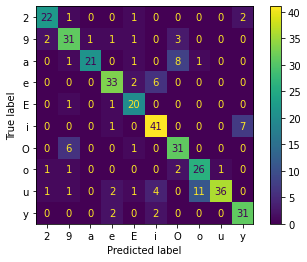

In [58]:
clf = BaggingClassifier(random_state=random_state, n_estimators=100)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('Bagging', clf))
plt.show()

## Stacking

              precision    recall  f1-score   support

           2     0.7667    0.8846    0.8214        26
           9     0.8378    0.7949    0.8158        39
           a     0.8800    0.6875    0.7719        32
           e     0.7674    0.8049    0.7857        41
           E     0.8636    0.8636    0.8636        22
           i     0.7800    0.7959    0.7879        49
           O     0.7619    0.8421    0.8000        38
           o     0.7073    0.9355    0.8056        31
           u     0.9730    0.6429    0.7742        56
           y     0.7381    0.8857    0.8052        35

    accuracy                         0.7995       369
   macro avg     0.8076    0.8138    0.8031       369
weighted avg     0.8148    0.7995    0.7984       369



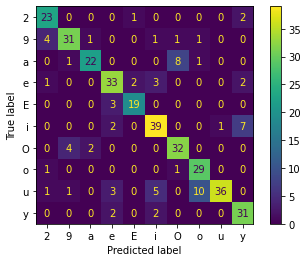

In [59]:
from sklearn.ensemble import StackingClassifier
clf = StackingClassifier(classifiers, cv='prefit')
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
plt.show()

In [57]:
clf = classifiers[-1][1]
from joblib import dump
dump(clf, '../models/rule_based.joblib')
dump(scaler, '../models/scaler.joblib')

['../models/scaler.joblib']

In [20]:
np.where((X_test[0] == formants_tot).all(axis=1))

(array([1097]),)

In [21]:
formants_tot[2023]

array([ 0.08206253, -0.0176552 , -1.5056552 , -1.1347111 ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ], dtype=float32)

In [22]:
for key, val in vowels.items():
    if '~' in key and not include_nasals:
        continue
    for i, val2 in enumerate(val):
        val3 = scaler.transform(np.array(val2[:4]).reshape(1, -1))[0]
        if 0.0060 < val3[0] < 0.0062:
            print(key, i)
            save_key = key
            save_i = i
j = 0
for file in v_files:
    if file.startswith(save_key):
        j += 1
    if save_i == j:
        print(file)
        break

o 134
o__f__0.14000__0.22000__m_o__mot__hzc1_mono.wav
